In [119]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import statsmodels.tsa.stattools as st
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [120]:
sb=pd.read_csv("mfd_bank_shibor.csv",parse_dates=["mfd_date"],date_parser=lambda date:pd.datetime.strptime(date,"%Y%m%d"))
it=pd.read_csv("mfd_day_share_interest.csv",parse_dates=["mfd_date"],date_parser=lambda date:pd.datetime.strptime(date,"%Y%m%d"))
bl=pd.read_csv("user_balance_table.csv",parse_dates=["report_date"],date_parser=lambda date:pd.datetime.strptime(date,"%Y%m%d"))
itsb=pd.merge(sb,it,on="mfd_date")
data=pd.merge(itsb,bl,left_on="mfd_date",right_on="report_date")
data.set_index("report_date",inplace=True)
data.pop("mfd_date")
data=data.groupby(by="report_date").sum()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  


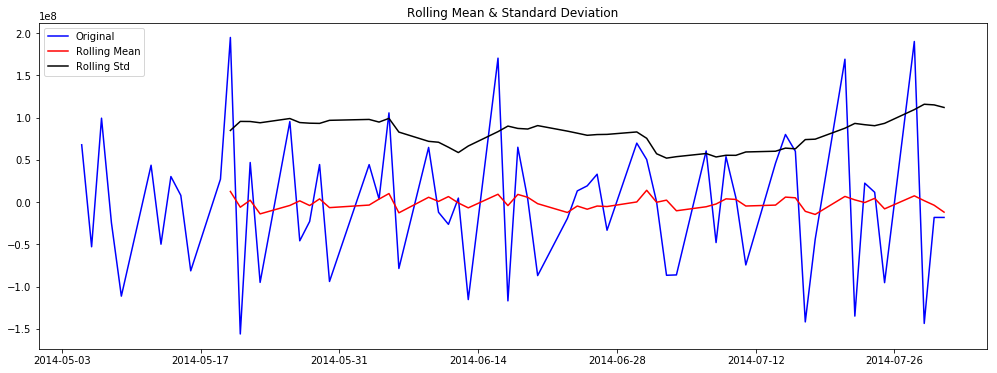

Results of Dickey-Fuller Test:
Test Statistic                 -5.042923
p-value                         0.000018
#Lags Used                      8.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [121]:
def test_stationarity(timeseries):
    """
    平稳性检验
    """
    rolmean = pd.rolling_mean(timeseries, window=12)  # 滑动平均数
    rolstd = pd.rolling_std(timeseries, window=12)  # 滑动标准差

    # 画出原时序、滑动平均数和滑动标准差的曲线
    plt.figure(figsize=(17,6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # 进行 Dickey-Fuller 测试:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data["total_purchase_amt"]['2014-05':'2014-07'].diff().dropna())

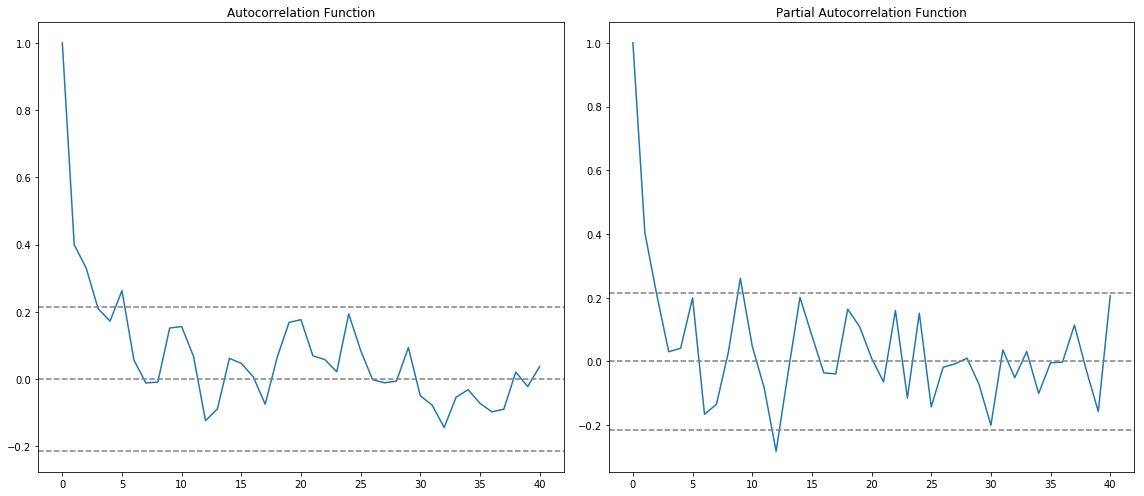

In [122]:
data_acf=acf(data["total_purchase_amt"]['2014-03':'2014-06'])
data_pacf=pacf(data["total_purchase_amt"]['2014-03':'2014-06'])
#Plot ACF: 
plt.figure(figsize=(16,7))
plt.subplot(121) 
plt.plot(data_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data["total_purchase_amt"]['2014-03':'2014-06'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data["total_purchase_amt"]['2014-03':'2014-06'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(data_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data["total_purchase_amt"]['2014-03':'2014-06'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data["total_purchase_amt"]['2014-03':'2014-06'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

c:\program files\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\program files\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


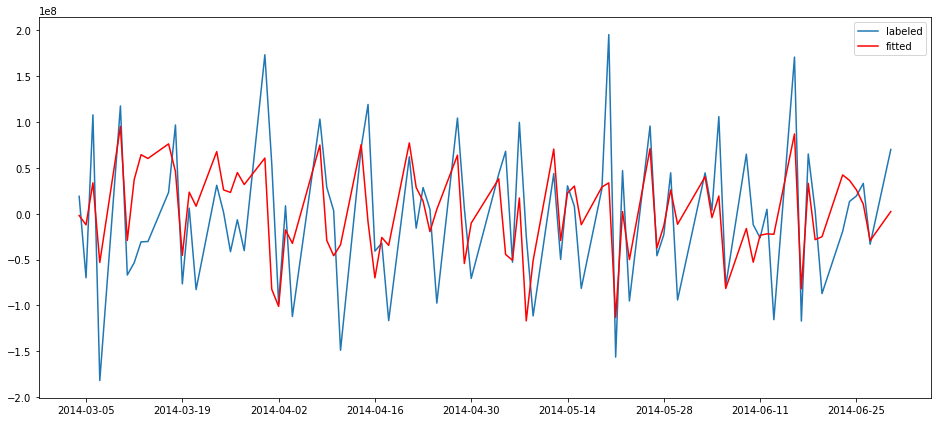

In [141]:
model = ARIMA(data["total_purchase_amt"]['2014-03':'2014-06'], order=(2, 1, 3))  
results_ARIMA = model.fit()  
plt.figure(figsize=(16,7))
plt.plot(data["total_purchase_amt"]['2014-03':'2014-06'].diff().dropna(),label="labeled")
plt.plot(results_ARIMA.fittedvalues, color='red',label="fitted")
plt.legend()

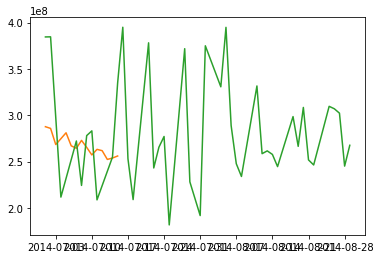

In [144]:
pred=results_ARIMA.predict(15)
plt.plot(pd.Series(pred,index=pd.date_range('7/1/2014', periods=15, freq='D')))
fcst,stderr,conf=results_ARIMA.forecast(15)
plt.plot(pd.Series(fcst,index=pd.date_range('7/1/2014', periods=15, freq='D')))
plt.plot(data["total_purchase_amt"]['2014-07':])

In [ ]:
data["total_purchase_amt"]['2014-05':'2014-07']